In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation (Shingling)

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [4]:
vectorizer_bigram = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b", ngram_range=(2, 2))
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bigram = vectorizer_bigram.fit_transform(list(s)).toarray()
df_bigram = pd.DataFrame(data = X_bigram, columns = vectorizer_bigram.get_feature_names())

In [5]:
df_bigram

,aiguillageetiquette_raffin.getimprimantedest com.mycompany.superviseur.client.modules.postpreparation.prepprep.console.etiqcolis.hashfnautomate.getautomatetouseprogaiguillage,aiguillageetiquettecasier.findimpr aiguillageetiquettecasier.getimprimantedest,aiguillageetiquettecasier.getimprimantedest com.mycompany.superviseur.client.modules.postpreparation.prepprep.console.etiqcolis.hashfnautomate.getautomatetouseprogaiguillage,avrilfnspenbembal.closecurrentpalette avrilfnspenbembal.quitprepprep,avrilfnspenbembal.quitprepprep com.mycompany.superviseur.client.modules.postpreparation.prepprep.console.fnmanager.quitprepprep,com.mycompany.achats.edi.modele.regleenvoicde__jvst5b2_1a6a.getrenvoimodif com.mycompany.achats.services.commande.impl.commandeserviceimpl.load,com.mycompany.achats.services.commande.impl.commandeserviceimpl.load com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2f.cglibload047,com.mycompany.achats.services.commande.impl.commandeserviceimpl.load com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2f.cglibload048,com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2f.cglibload047 com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2ffastclassbycglib86c9e3d0.invoke,com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2f.cglibload048 com.mycompany.achats.services.commande.impl.commandeserviceimplenhancerbycglib69294e2ffastclassbycglib86c9e3d0.invoke,...,sun.reflect.generatedmethodaccessor5281.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.generatedmethodaccessor575096.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.generatedmethodaccessor6410.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.generatedmethodaccessor80608.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.generatedmethodaccessor80619.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.generatedmethodaccessor844599.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.generatedmethodaccessor853912.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.generatedmethodaccessor93404.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.nativemethodaccessorimpl.invoke sun.reflect.delegatingmethodaccessorimpl.invoke,sun.reflect.nativemethodaccessorimpl.invoke0 sun.reflect.nativemethodaccessorimpl.invoke
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 2. MinHash

In [6]:
nb_permutations = 64
size_vector = 16
embeddings = min_hash (nb_permutations, size_vector, df_bigram)

# 3. Locality Sensitive Hashing

In [7]:
params = lsh_hyperparams(nb_permutations)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

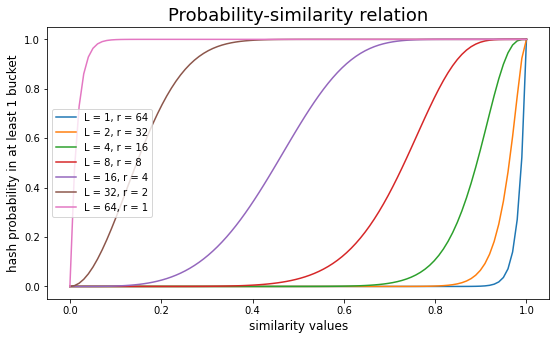

In [8]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [9]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, embeddings, size_vector, df_measures, 'Jaccard-bigram', trace = False)

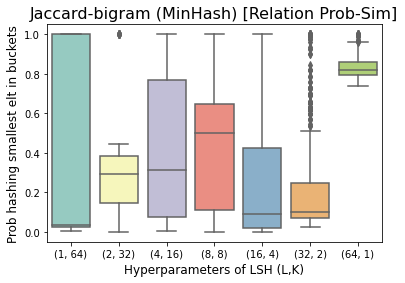

In [10]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Jaccard-bigram (MinHash) [Relation Prob-Sim]', fontsize = 16)
plt.show()

In [11]:
'L = K = 8'
L, K = params[3]
L, K

(8, 8)

In [12]:
hash_tables = create_hash_tables(L, K, size_vector, embeddings)

In [13]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index = 1

In [14]:
set_near_duplicates = near_duplicates(L, K, size_vector, index, embeddings, hash_tables)
set_near_duplicates

{0, 1, 9, 34, 58, 71, 157, 304, 323, 413, 441, 619, 831}

In [15]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [16]:
near_duplicates_sim = df_measures['Jaccard-bigram'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

0       0.818182
1006    0.818182
1055    0.769231
1410    0.769231
1616    0.642857
1031    0.583333
1828    0.562500
1320    0.538462
1154    0.500000
1068    0.461538
1438    0.421053
1301    0.250000
Name: Jaccard-bigram, dtype: float64

In [17]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Jaccard-bigram', n_stacks, n_duplicate_pairs)
set_real_nns

{0, 9, 34, 41, 58, 152, 155, 413, 431, 619, 780, 928}

In [18]:
real_nns_sim[:n_duplicate_pairs]

0       0.818182
1006    0.818182
1055    0.769231
1149    0.769231
1410    0.769231
1428    0.714286
1925    0.666667
1616    0.642857
1152    0.642857
1038    0.625000
1777    0.600000
1031    0.583333
dtype: float64

# 4. Metrics (MinHash)

## 4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [19]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, embeddings, size_vector, df_measures, k_first_positions, 'Jaccard-bigram')

0.897

In [20]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], embeddings, size_vector, df_measures, k_first_positions, 'Jaccard-bigram')

0.9659574468085106

-----------------------------------------------------------------

In [21]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, embeddings, size_vector, df_measures, k_first_positions, 'Jaccard-bigram')

0.9146666666666659

In [22]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], embeddings, size_vector, df_measures, k_first_positions, 'Jaccard-bigram')

0.9293394777265745

-----------------------------------------------------------------

In [23]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, embeddings, size_vector, df_measures, k_first_positions, 'Jaccard-bigram')

0.9167999999999995

In [24]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], embeddings, size_vector, df_measures, k_first_positions, 'Jaccard-bigram')

0.9108974358974362

## 4.2. Generalized MRR

In [25]:
df_knns = mean_generalized_mrr(n_stacks, params, embeddings, size_vector, df_measures ,'Jaccard-bigram', trace = True)
df_knns.mean(skipna = True, axis = 0)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(16, 4)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(32, 2)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(64, 1)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    0.980392
(2, 32)    0.936206
(4, 16)    0.965072
(8, 8)     0.936132
(16, 4)    0.872925
(32, 2)    0.930513
(64, 1)    0.998311
dtype: float64

In [26]:
df_knns.mean(skipna = True, axis = 0).mean()

0.9456500709205525

## 4.3. Recall w.r.t. LSH

In [27]:
df_recall = recall_all(n_stacks, params, embeddings, size_vector, df_measures ,'Jaccard-bigram', trace = True)
df_recall.mean(skipna = True)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(16, 4)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(32, 2)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(64, 1)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    1.000000
(2, 32)    1.000000
(4, 16)    0.786957
(8, 8)     0.829349
(16, 4)    0.861792
(32, 2)    0.887785
(64, 1)    0.982652
dtype: float64

In [28]:
df_recall.mean(skipna = True)

(1, 64)    1.000000
(2, 32)    1.000000
(4, 16)    0.786957
(8, 8)     0.829349
(16, 4)    0.861792
(32, 2)    0.887785
(64, 1)    0.982652
dtype: float64

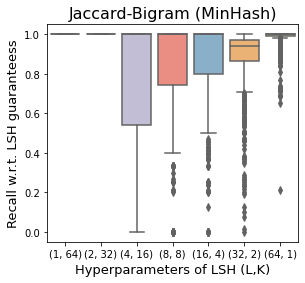

In [29]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guaranteess", fontsize = 13)
plt.title('Jaccard-Bigram (MinHash)', fontsize = 16)
plt.savefig('Results/MinHash/Recall-LSH', bbox_inches='tight')
plt.show()

## 4.4. Precision w.r.t. LSH

In [30]:
df_precision = precision_all(n_stacks, params, embeddings, size_vector, df_measures ,'Jaccard-bigram', trace = True)
df_precision.mean(skipna = True, axis = 0)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(16, 4)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(32, 2)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(64, 1)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    0.411765
(2, 32)    0.159091
(4, 16)    0.456671
(8, 8)     0.700454
(16, 4)    0.596156
(32, 2)    0.721392
(64, 1)    1.000000
dtype: float64

In [31]:
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.411765
(2, 32)    0.159091
(4, 16)    0.456671
(8, 8)     0.700454
(16, 4)    0.596156
(32, 2)    0.721392
(64, 1)    1.000000
dtype: float64

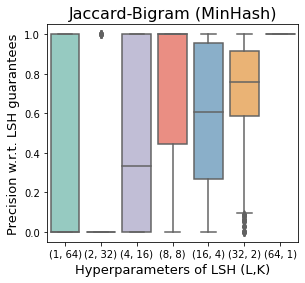

In [32]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Jaccard-Bigram (MinHash)', fontsize = 16)
plt.savefig('Results/MinHash/precision-LSH', bbox_inches='tight')
plt.show()

In [33]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.411765
(2, 32)    0.159091
(4, 16)    0.421705
(8, 8)     0.673571
(16, 4)    0.623058
(32, 2)    0.760257
(64, 1)    0.990375
dtype: float64

## 4.5. Fscore w.r.t. LSH

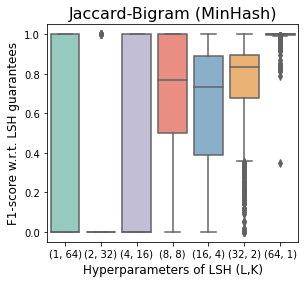

In [34]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 12)
plt.title('Jaccard-Bigram (MinHash)', fontsize = 16)
plt.savefig('Results/MinHash/fscore-LSH', bbox_inches='tight')
plt.show()